In [ ]:
# Install necessary libraries
!pip install rasterio geopandas scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 19.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Step 1: Upload the multiband GeoTIFF image and training data GeoPackage to Google Colab (or mount your Google Drive folder)

# Step 2: Read the multiband tiff image

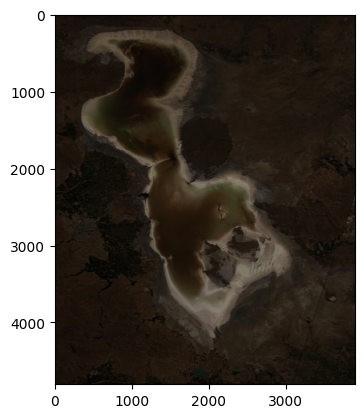

In [ ]:
image_path = '/content/drive/MyDrive/Urmia/imagies/2017_LakeU_Sentinel2-null.tif'  # Update with the correct file path
image = rasterio.open(image_path)

# Visualize True Color image
# Read the band values into numpy arrays
red = image.read(3)
green = image.read(2)
blue = image.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

rgb = np.dstack((redn, greenn, bluen))

plt.imshow(rgb)

# Step 3: Read the vector training areas from GeoPackage

In [ ]:
training_data_path = '/content/drive/MyDrive/Urmia/Classification/ROI/2017/ROI2017.gpkg'  # Update with the correct file path
training_data = gpd.read_file(training_data_path, layer='ROI2017')
training_data.head()

,id,geometry
0,1,"MULTIPOLYGON (((45.92347 38.25999, 45.91513 38..."
1,2,"MULTIPOLYGON (((45.37117 38.13677, 45.38993 38..."
2,2,"MULTIPOLYGON (((45.25191 38.17388, 45.26963 38..."
3,3,"MULTIPOLYGON (((45.33030 38.22892, 45.35178 38..."
4,3,"MULTIPOLYGON (((45.12869 38.22496, 45.15558 38..."


# Step 4: Extract pixel values from the image (X) corresponding to training data (y)

In [ ]:
X = []  # Feature vector
y = []  # Class labels

for index, row in training_data.iterrows():
    # Extract pixel values within the boundaries of each training area
    geom = row['geometry']
    out_image, out_transform = mask(image, [geom], crop=True)
    out_image = np.moveaxis(out_image, 0, -1)  # Move axis to match sklearn format
    flat_pixels = out_image.reshape(-1, out_image.shape[-1])
    for pixel in flat_pixels:
        X.append(pixel)
        y.append(row['id'])


# Step 5: Split data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # test_size = training/test ratio

# Step 6: Train a Random Forest classifier

In [ ]:
#classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier = GradientBoostingClassifier(random_state=42) #use a different classifier
classifier.fit(X_train, y_train)

#---------------------------------------------

## Initialize the Decision Tree classifier
#classifier = DecisionTreeClassifier(random_state=42)

## Fit the classifier to the training data
#classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

# Step 7: Evaluate the classifier

In [ ]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8753577511281232


In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

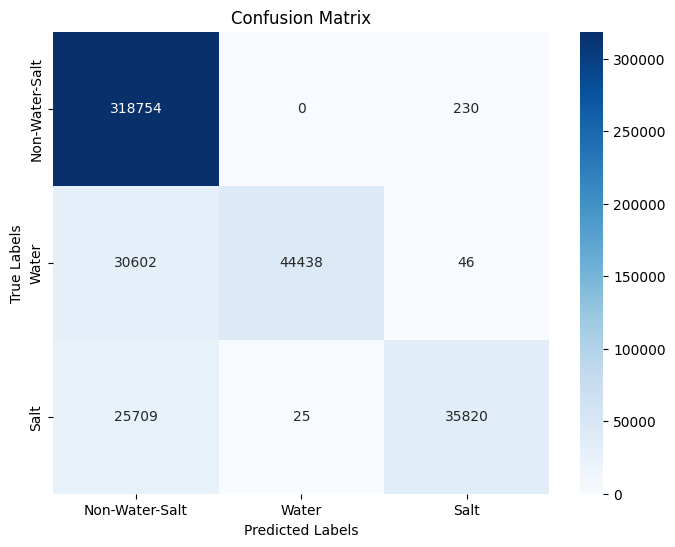

In [ ]:
# Plot confusion matrix with labels
custom_labels = ['Non-Water-Salt', 'Water', 'Salt'] # {1:'not_dune', 2:'dune'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 8: Classify the image

In [ ]:
# Reshape image data to match the structure of training data
image_data = image.read().transpose(1, 2, 0)  # Move bands to the last axis
rows, cols, bands = image_data.shape
image_data_reshaped = image_data.reshape(rows * cols, bands)

In [ ]:
# Classify the image
predicted_classes = classifier.predict(image_data_reshaped)
predicted_classes_reshaped = predicted_classes.reshape(rows, cols)

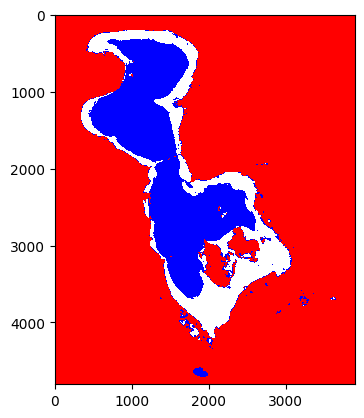

<Axes: >

In [ ]:
# Visualize the classified image

colors = ['red', 'blue', 'white']
class_bins = [1, 2, 3] # {1:'Non-Water-Salt', 2:'WAter', 2:'salt'}
cmap = ListedColormap(colors)


show(predicted_classes_reshaped, cmap=cmap)

# Step 9: Save the classified image as a new GeoTIFF file

In [ ]:
output_image_path = '/content/drive/MyDrive/Urmia/Classification/Decision Tree/2017/2017-D3-classified.tif'
with rasterio.open(output_image_path, 'w', **image.meta) as dst:
    dst.write(predicted_classes_reshaped.astype(rasterio.uint8), 1)